In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torch 
import numpy as np 
from models.decoder_transformer import DecoderOnlyAudioTransformer 
from utils.visualization import plot_spectrogram 
import os 
import soundfile as sf 
import librosa 

def load_checkpoint(model, checkpoint_path):
    """
    Load a pre-trained model checkpoint.
    
    Args:
        model (nn.Module): The model to load the checkpoint into.
        checkpoint_path (str): Path to the checkpoint file.
    """
    checkpoint = torch.load(checkpoint_path) 
    model.load_state_dict(checkpoint["model_state_dict"]) 
    model.eval() 
    print(f"Loaded checkpoint from {checkpoint_path}") 

def generate_audio(model, input_spectrogram, max_length=313): 
    """
    Generate audio using the model.
    
    Args:
        model (nn.Module): The pre-trained model.
        input_spectrogram (torch.Tensor): Input spectrogram of shape (1, seq_len, input_dim).
        max_length (int): Maximum sequence length (time steps).
    
    Returns:
        generated_spectrogram (torch.Tensor): Generated spectrogram of shape (1, max_length, input_dim).
    """
    with torch.no_grad():
        # Initialize the output sequence with the input spectrogram
        output_sequence = input_spectrogram.clone()

        # Generate the remaining sequence
        for i in range(input_spectrogram.size(1), max_length):
            # Prepare the input sequence
            src = output_sequence[:, :i, :]

            # Forward pass (autoregressive generation)
            output = model(src, src)  # Use src as both input and target during inference

            # Append the predicted frame to the output sequence
            output_sequence = torch.cat([output_sequence, output[:, -1:, :]], dim=1)

        return output_sequence

def mel_to_audio(mel_spectrogram, sr=16000, n_fft=1024, hop_length=256, n_mels=128):
    # Transpose and convert to numpy
    mel_spectrogram = mel_spectrogram.transpose(0, 1).numpy()

    # Denormalize the melspectrogram
    mel_spectrogram = (mel_spectrogram -1)*80 # 80 is the max db value
  
    # Reverse dB to power conversion
    print('before db',mel_spectrogram.min(), mel_spectrogram.max(),mel_spectrogram.mean(),mel_spectrogram.shape)
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)

    print(mel_spectrogram.min(), mel_spectrogram.max(),mel_spectrogram.mean(),mel_spectrogram.shape)

    # Use built-in librosa method to invert the mel spectrogram to a linear spectrogram
    spec_reconstructed = librosa.feature.inverse.mel_to_stft(
        mel_spectrogram, sr=sr, n_fft=n_fft
    )

    print(spec_reconstructed.min(), spec_reconstructed.max(),spec_reconstructed.mean(),spec_reconstructed.shape)


    print("Checking for NaNs or infinities:")
    print(f"NaNs: {torch.isnan(generated_spectrogram).any()}")
    print(f"Infinities: {torch.isinf(generated_spectrogram).any()}")
    print(f"Min value: {generated_spectrogram.min()}")
    print(f"Max value: {generated_spectrogram.max()}")

    # Reconstruct audio using Griffin-Lim algorithm
    audio_reconstructed = librosa.griffinlim(
        spec_reconstructed, n_fft=n_fft, hop_length=hop_length, n_iter=60
    )

    return audio_reconstructed

In [26]:
import torch
import yaml
import soundfile as sf
from models.decoder_transformer import DecoderOnlyAudioTransformer

# Configuration
checkpoint_path = "outputs/checkpoints/epoch_29_val_loss_0.04746504376331965_model.pt"  # Update with your checkpoint path
input_spectrogram_path = "data/processed/summer_night_segment_35.pt"  # Update with your training data path
output_audio_path = "generated_audio.wav"

def load_config(config_path="configs/config.yaml"):
    """
    Load configuration from a YAML file.
    
    Args:
        config_path (str): Path to the YAML configuration file.
    
    Returns:
        config (dict): Configuration dictionary.
    """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

config = load_config()
input_dim = config["input_dim"]
model_dim = config["model_dim"]
num_heads = config["num_heads"]
num_layers = config["num_layers"]
max_length = config["max_length"]  # Corresponds to 5 seconds of audio

# Initialize the model
model = DecoderOnlyAudioTransformer(input_dim, model_dim, num_heads, num_layers, max_length)
model.eval()

# Load the pre-trained checkpoint 
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda')) 
model.load_state_dict(checkpoint['model_state_dict']) 
print("Checkpoint loaded successfully.") 

# Load the 1-second input spectrogram from the training data 
input_spectrogram = torch.load(input_spectrogram_path)  # Shape: (1, seq_len, input_dim) 
input_spectrogram = input_spectrogram.unsqueeze(0)  # Shape: (1, seq_len, input_dim) 
input_spectrogram = input_spectrogram[:, :128, :]  # Take the first 63 time steps (4 second) 

# Generate the remaining spectrogram using the model's inference method 
with torch.no_grad(): 
    generated_spectrogram = model.inference(initial_input=input_spectrogram, max_length=max_length) 
    
generated_spectrogram = np.squeeze(generated_spectrogram) 

audio = mel_to_audio( 
        np.squeeze(generated_spectrogram),
        sr=config['sample_rate'],
        n_fft=config['n_fft'],
        hop_length=config['hop_length'],
        n_mels=config['n_mels']
    )

# Save the generated audio to a file
sf.write(output_audio_path, audio, config['sample_rate'])  # Assuming a sample rate of 22050 Hz
print(f"Generated audio saved to {output_audio_path}")


C:\Users\xiche\AppData\Local\Temp\ipykernel_11116\384010708.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.

Checkpoint loaded successfully.


C:\Users\xiche\AppData\Local\Temp\ipykernel_11116\384010708.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_spectrogram = torch.load(input_spectrogram_path)  # Sh

before db -80.0 -5.6619024 -53.41662 (160, 861)
1e-08 0.27152497 0.0008592513 (160, 861)
0.0 2.7226193 0.02234864 (1025, 861)
Checking for NaNs or infinities:
NaNs: False
Infinities: False
Min value: 0.0
Max value: 0.9292262196540833
Generated audio saved to generated_audio_2.wav


In [28]:
input_spectrogram = torch.load(input_spectrogram_path) 
audio = mel_to_audio( 
        np.squeeze(input_spectrogram),
        sr=config['sample_rate'],
        n_fft=config['n_fft'],
        hop_length=config['hop_length'],
        n_mels=config['n_mels']
    )

sf.write('generate_audio_orig.wav', audio, config['sample_rate'])

C:\Users\xiche\AppData\Local\Temp\ipykernel_11116\4110936820.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_spectrogram = torch.load(input_spectrogram_path)


before db -80.0 0.0 -54.684032 (160, 862)
1e-08 1.0 0.0020046933 (160, 862)
0.0 5.3952575 0.027192743 (1025, 862)
Checking for NaNs or infinities:
NaNs: False
Infinities: False
Min value: 0.0
Max value: 0.9292262196540833


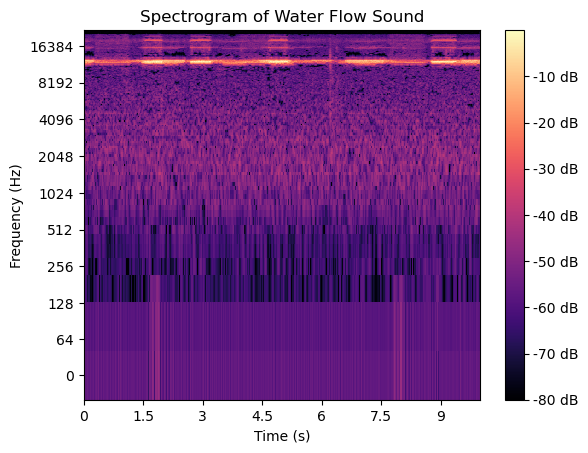

In [47]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_path = "generate_audio_orig.wav"
audio, sr = librosa.load(audio_path, sr=config['sample_rate'])  # Load with original sampling rate

spectrogram = librosa.feature.melspectrogram(
    y=audio, 
    sr=config['sample_rate'],
    n_mels= 256,
    n_fft=config['n_fft'],  # Make sure to use n_fft, not n_mels here
    hop_length=config['hop_length'],
    window='hann',
    center=True,
    pad_mode='reflect',
    power=2.0
) 
spectrogram = librosa.power_to_db(spectrogram, ref=np.max) 

librosa.display.specshow(spectrogram, sr=config['sample_rate'], x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Water Flow Sound")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


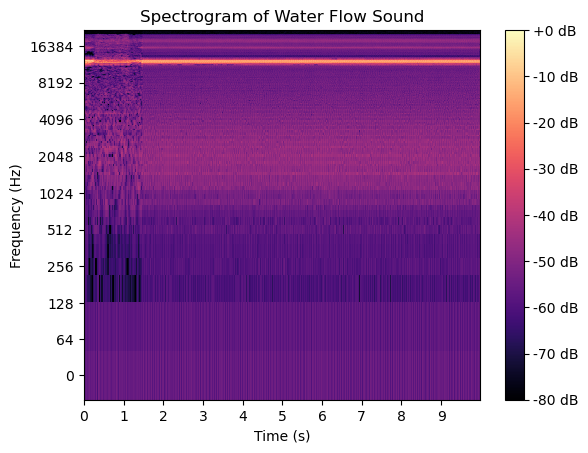

In [48]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_path = "generated_audio_2.wav"
audio, sr = librosa.load(audio_path, sr=config['sample_rate'])  # Load with original sampling rate

spectrogram = librosa.feature.melspectrogram(
    y=audio, 
    sr=config['sample_rate'],
    n_mels= 256,
    n_fft=config['n_fft'],  # Make sure to use n_fft, not n_mels here
    hop_length=config['hop_length'],
    window='hann',
    center=True,
    pad_mode='reflect',
    power=2.0
) 
spectrogram = librosa.power_to_db(spectrogram, ref=np.max) 

librosa.display.specshow(spectrogram, sr=config['sample_rate'], x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Water Flow Sound")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


In [36]:
librosa.display.specshow(generated_spectrogram, sr=config['sample_rate'], x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Water Flow Sound")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

TypeError: Cannot interpret 'torch.float32' as a data type

In [25]:
x = torch.load(input_spectrogram_path)
x[252:253]

C:\Users\xiche\AppData\Local\Temp\ipykernel_1220\1241725397.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(input_spectrogram_path)


tensor([[0.5263, 0.7642, 0.8458, 0.8230, 0.7742, 0.7098, 0.7671, 0.8128, 0.7810,
         0.7791, 0.7914, 0.7703, 0.7433, 0.7137, 0.6601, 0.6856, 0.6911, 0.5773,
         0.6575, 0.7304, 0.7220, 0.7312, 0.6519, 0.6959, 0.7739, 0.7607, 0.7916,
         0.7522, 0.6802, 0.6109, 0.6827, 0.7367, 0.7556, 0.7476, 0.7193, 0.6942,
         0.7421, 0.7741, 0.7651, 0.7232, 0.7254, 0.7417, 0.7042, 0.6689, 0.6575,
         0.6141, 0.6398, 0.6491, 0.6758, 0.6033, 0.6133, 0.6325, 0.6404, 0.6607,
         0.7104, 0.6832, 0.6031, 0.5532, 0.5709, 0.5875, 0.5969, 0.6255, 0.6172,
         0.5922, 0.6007, 0.5631, 0.5298, 0.5375, 0.6300, 0.6287, 0.5833, 0.5972,
         0.5610, 0.5848, 0.6172, 0.5601, 0.5199, 0.5811, 0.6177, 0.6614, 0.6144,
         0.5074, 0.6487, 0.6579, 0.5374, 0.5729, 0.6192, 0.5651, 0.5561, 0.5791,
         0.5632, 0.5462, 0.6978, 0.7932, 0.7368, 0.6915, 0.6762, 0.7082, 0.7106,
         0.7079, 0.6449, 0.5767, 0.5255, 0.5882, 0.5398, 0.5520, 0.5635, 0.5250,
         0.5318, 0.5458, 0.5

In [32]:
x[252:,3:4]

tensor([[0.8230],
        [0.8518],
        [0.7333],
        [0.6770],
        [0.7279],
        [0.7675],
        [0.7858],
        [0.6468],
        [0.8137],
        [0.8682],
        [0.8250],
        [0.7390],
        [0.8104],
        [0.7715],
        [0.8084],
        [0.8347],
        [0.7963],
        [0.5494],
        [0.7157],
        [0.7970],
        [0.8069],
        [0.8201],
        [0.8111],
        [0.8167],
        [0.7964],
        [0.6847],
        [0.7078],
        [0.8443],
        [0.8041],
        [0.6857],
        [0.8395],
        [0.8709],
        [0.7647],
        [0.7972],
        [0.8047],
        [0.8411],
        [0.7950],
        [0.7500],
        [0.7172],
        [0.5839],
        [0.6583],
        [0.7354],
        [0.6668],
        [0.7306],
        [0.7151],
        [0.6274],
        [0.7144],
        [0.8066],
        [0.9022],
        [0.8745],
        [0.7905],
        [0.8774],
        [0.8773],
        [0.8249],
        [0.6992],
        [0

In [33]:
generated_spectrogram[252:,3:4]

tensor([[0.5450],
        [0.5440],
        [0.5487],
        [0.5527],
        [0.5517],
        [0.5457],
        [0.5376],
        [0.5319],
        [0.5350],
        [0.5445],
        [0.5511],
        [0.5482],
        [0.5355],
        [0.5203],
        [0.5120],
        [0.5133],
        [0.5210],
        [0.5291],
        [0.5326],
        [0.5302],
        [0.5251],
        [0.5208],
        [0.5203],
        [0.5206],
        [0.5202],
        [0.5190],
        [0.5179],
        [0.5197],
        [0.5240],
        [0.5295],
        [0.5332],
        [0.5323],
        [0.5276],
        [0.5242],
        [0.5263],
        [0.5327],
        [0.5394],
        [0.5443],
        [0.5480],
        [0.5503],
        [0.5514],
        [0.5523],
        [0.5533],
        [0.5535],
        [0.5545],
        [0.5566],
        [0.5585],
        [0.5584],
        [0.5553],
        [0.5502],
        [0.5459],
        [0.5451],
        [0.5487],
        [0.5530],
        [0.5555],
        [0